<center><span style="color:#336E7B; font-size:300%; font-family:Impact">Facial Recognition in Python</span></center>
<center><span style="color:#34495E; font-size:200%; font-family:Impact; line-height: 50px">Sean Wade</span></center>
<hr style="height: 2px">

<div style="background-color: #778899">
<img src="facial-recognition.jpg">
</div>

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import linalg as la
from os import walk
from scipy.ndimage import imread
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import random
from random import sample

<div style="background-color: #E3F8FA; width: 100%; padding:30px; border">
<b><span style="color:#04353B; font-size:150%; font-family:Maraco">Creating the Dataset</span></b>
<p style="line-height: 25px">We begin by creating a function to load all the faces. The code we will be using traverses through the given directory and loads all JPEG images. The images are flattened and then stored vertically in a single matrix.</p>
</div>

In [3]:
def getFaces(path='./faces94'):
    """Traverse the directory specified by 'path' and return an array containing
    one column vector per subdirectory.
    """
    # Traverse the directory and get one image per subdirectory
    faces = []
    for (dirpath, dirnames, filenames) in walk(path):
        for f in filenames:
            if f[-3:]=="jpg": # only get jpg images
                # load image, convert to grayscale, flatten into vector
                face = imread(dirpath+"/"+f).mean(axis=2).ravel()
                faces.append(face)
                break
    # put all the face vectors column-wise into a matrix
    return np.array(faces).T

#### Helper functions to convert and display image

In [4]:
def show(im, w=200, h=180):
    """Plot the flattened grayscale image 'im' of width 'w' and height 'h'."""
    plt.imshow(im.reshape((w,h)), cmap=cm.Greys_r)
    plt.show()
    
def show2(test_image, result, input_image="Inputed Image", match="Closest match", w=200, h=180):
    """Convenience function for plotting two flattened grayscale images of
    the specified width and height side by side
    """
    plt.subplot(121)
    plt.title(input_image)
    plt.imshow(test_image.reshape((w,h)), cmap=cm.Greys_r)
    plt.axis("off")
    plt.subplot(122)
    plt.title(match)
    plt.imshow(result.reshape((w,h)), cmap=cm.Greys_r)
    plt.axis("off")
    plt.show()

<div style="background-color: #E3F8FA; width: 100%; padding:30px">
<b><span style="color:#04353B; font-size:150%; font-family:Maraco">Shift By the Mean</span></b>
<p style="line-height: 25px">
To accentuate the unique features of each of the faces, we will perform a mean shift.  To do this we calculate the mean face, $\mu$, by taking the average value of each part of each face image.  This is given by the formula:
$$\mu = \frac{1}{k}\sum_{i=1}^{k}f_i$$
</p>
</div>

In [5]:
def meanShift(face_matrix):
    """Takes in a nxm np.array comprised of flattened images along the columns and returns a nx1
    vector of the average face.
    """
    mu = np.mean(face_matrix, axis=1)
    return mu

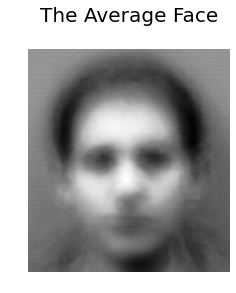

In [6]:
face_matrix = getFaces()
mu = meanShift(face_matrix)
plt.title("The Average Face", fontsize=20, y=1.1)
plt.axis("off")
show(mu)

<div style="background-color: #E3F8FA; width: 100%; padding:30px">
<p style="line-height: 25px">
Now that we have the average we scale all the other images by taking their difference to the mean.  This we will denote as $\bar{F} := f_i - \mu$.  Making the new shifted vector dataset $$\bar{F} = [ ~ \bar{f_1} ~ \bar{f_2} \cdots \bar{f_k} ~ ]$$
</p>
</div>

In [7]:
def faceDifferences(face_matrix, mu):
        Fbar = face_matrix - np.vstack(mu)
        return Fbar

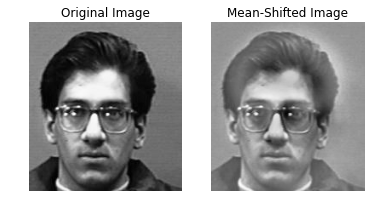

In [8]:
Fbar = faceDifferences(face_matrix, mu)
show2(face_matrix[:,28], Fbar[:,28], "Original Image", "Mean-Shifted Image")

<div style="background-color: #E3F8FA; width: 100%; padding:30px">
<b><span style="color:#04353B; font-size:150%; font-family:Maraco">Project to a Subspace: Eigenfaces</span></b>
<p style="line-height: 25px">
Computing the vector $\bar{f_i}$ the minimizes $||{\bar{g} - \bar{f_i}}||_2$ will give us the closest match, however this is way to big of a vector to be practical to calculate.  To solve this we use the singular value decoomposition of a matrix to get the eigenvectors that are assosiated with the best minimal span.  We project or faces to this subspace with the projector $P_s = U_sU_s^T$. 
</p>
</div>

In [9]:
def eigenFaces(Fbar):
    U = la.svd(Fbar, full_matrices=False)[0]
    return U

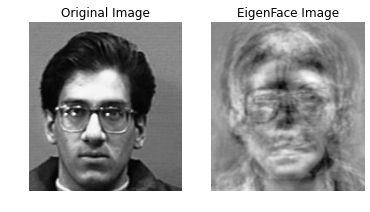

In [10]:
U = eigenFaces(Fbar)
show2(face_matrix[:,28], U[:,28], "Original Image", "EigenFace Image")

<div style="background-color: #E3F8FA; width: 100%; padding:30px">
<b><span style="color:#04353B; font-size:150%; font-family:Maraco">Chane of Basis</span></b>
<p style="line-height: 25px">
Now  we have our new **space spaned by the EigenFaces**. Next we must convert the faces we have into faces represented in this basis.  Below shows the affects of this change in quality loss.  Due to the power of eigenvalues it is not very different than the original and **WAY** faster and better.
</p>
</div>

In [11]:
def basisProject(A, U, s=38):
    Ut = U[:,:s].T
    return Ut.dot(A)

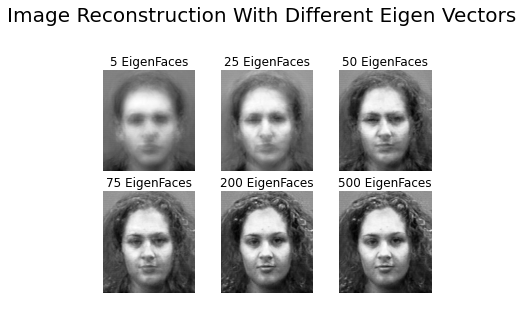

In [12]:
x = 1
e_number = [5, 25, 50, 75, 200, 500]
for s in e_number: 
    # Project face onto subspace spaned by s eigenvalues
    face_in_eigen_basis = basisProject(face_matrix[:,2], U, s)
    # Project face back to R_mn
    face_projected_back = U[:,:s].dot(np.vstack(face_in_eigen_basis))
    # Add the mean back
    reconstructed_face = face_projected_back + np.vstack(mu)
    plt.subplot(2,3,x)
    plt.suptitle("Image Reconstruction With Different Eigen Vectors",fontsize=20, y = 1.12)
    plt.title("%s EigenFaces" % s)
    plt.axis("off")
    plt.imshow(reconstructed_face.reshape((200,180)), cmap=cm.Greys_r)
    x += 1
plt.show()
    

<div style="background-color: #E3F8FA; width: 100%; padding:30px">
<b><span style="color:#04353B; font-size:150%; font-family:Maraco">Recognizing the Face!</span></b>
<p style="line-height: 25px">
Finally, we are ready to identify which mean-shifted image $\bar{f_i}$ is closest to a input face.  We begin by projecting all vectors to some s-dimensional subspace and writing them in terms of an orthonormal basis for that subspace. This is accomplished with $U_s^T$:
$$\bar{f_i} = U_s^T(f_i - \mu) \qquad \bar{g_i} = U_s^T(g - \mu)$$
Since the columns of Us are an
orthonormal basis, we get the same result doing the computation in this basis as
we would in the standard Euclidean basis.
$$i^* = \text{argmin}_i \:||\bar{f_i} - \bar{g}||_2$$
This gives the $i^*$-th best face as the closest match.
</p>
</div>

### For conviniance we will place all our code in the class FacialRec

In [13]:
class FacialRec:
##########Members##########
# F, mu, Fbar, and U
###########################
    def __init__(self,path):
        self.initFaces(path)
        self.initMeanImage()
        self.initDifferences()
        self.initEigenfaces()

    def initFaces(self, path):
        self.F = getFaces(path)
        
    def initMeanImage(self):
        self.mu = np.mean(self.F, axis=1)
             
    def initDifferences(self):
        self.Fbar = self.F - np.vstack(self.mu)
    
    def initEigenfaces(self):
        self.U = la.svd(self.Fbar, full_matrices=False)[0]
    
    def show(self, face_num):
        show(self.F[:,face_num])
        
    def project(self, A, s=38):
        c = self.U[:,:s]
        return c.T.dot(A)      
    
    def findNearest(self, image, s=38):
        Fhat = self.project(self.Fbar, s)
        ghat = self.project((np.vstack(image) - np.vstack(self.mu)), s)
        index = np.linalg.norm(Fhat - np.vstack(ghat), axis=0).argmin()
        return index

### This code pulls random pictures of people in the dataset, and we will use our facial recognition algorithm to find out who it is.

In [14]:
def sampleFaces(n_tests, path="./faces94"):
    """Return an array containing a sample of n_tests images contained
    in the path as flattened images in the columns of the output
    """
    files = []
    for (dirpath, dirnames, filenames) in walk(path):
        for f in filenames:
            if f[-3:]=="jpg": # only get jpg images
                files.append(dirpath+"/"+f)

    #Get a sample of the images
    test_files = random.sample(files, n_tests)
    #Flatten and average the pixel values
    images = np.array([imread(f).mean(axis=2).ravel() for f in test_files]).T
    return images

<center><span style="color:#336E7B; font-size:300%; font-family:Impact">And now we have...</span></center>

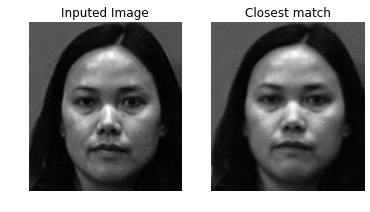

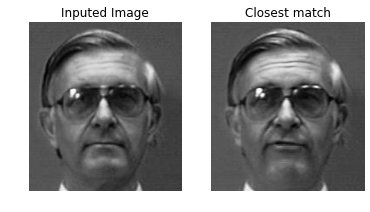

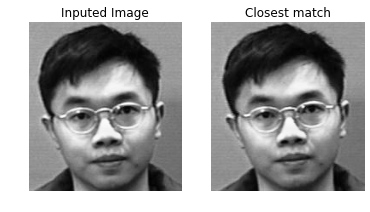

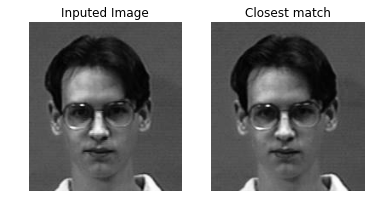

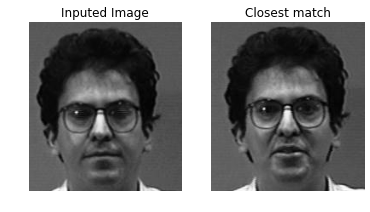

In [17]:
recognizer = FacialRec("./faces94")
test_faces = sampleFaces(5)
for x in xrange(5):
    match_index = recognizer.findNearest(test_faces[:,x], 100)
    show2(face_matrix[:,match_index], test_faces[:,x])